In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = "../../../data/satellite-imagery/"
sz=64
arch = resnext50 #původně 34
bs=64

In [4]:
torch.cuda.is_available()

True

In [5]:
#MODEL

In [6]:
from planet_copy1 import f2
metrics = [f2]

In [7]:
train_labels_df = pd.read_csv(f"{PATH}train_v2.csv")
n = int(len(train_labels_df)*0.2)
val_idxs=np.array(train_labels_df.sample(n).index)

In [8]:
# different augumentations
def get_data(sz,bs):
    tfms = tfms_from_model(arch,sz,aug_tfms=transforms_top_down,max_zoom=1.05)
    data = ImageClassifierData.from_csv(PATH,folder='train-jpg',csv_fname=f"{PATH}train_v2.csv",
                                        bs=bs,tfms=tfms,val_idxs=val_idxs,test_name='test-jpg',
                                        suffix='.jpg',num_workers=4)
    return data

In [31]:
data = get_data(sz,bs)

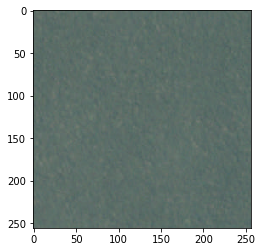

In [32]:
plt.imshow(plt.imread(f'{PATH}{data.val_ds.fnames[0]}'))

In [33]:
len(data.val_ds)/bs,len(data.trn_ds)/bs

(126.484375, 506.0)

In [34]:
x,y = next(iter(data.val_dl))

In [35]:
y


    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     1
       ...          ⋱          ...       
    0     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [36]:
list(zip(data.classes,y[63]))

[('agriculture', 0.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 1.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 0.0)]

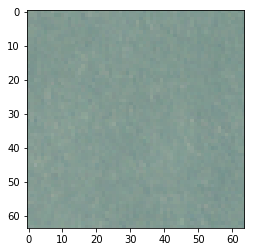

In [37]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4)

In [12]:
data = get_data(sz,bs)

In [15]:
data = data.resize(int(sz*1.3),'tmp')

In [40]:
sz

64

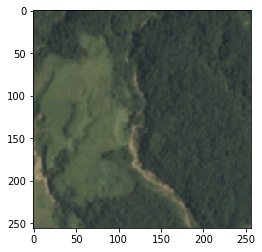

In [44]:
plt.imshow(plt.imread(f'{PATH}{data.trn_ds.fnames[0]}'))

In [13]:
learn = ConvLearner.pretrained(arch,data,ps=0.5,metrics=metrics)

epoch      trn_loss   val_loss   f2                          
    0      0.239768   0.378539   0.732281  



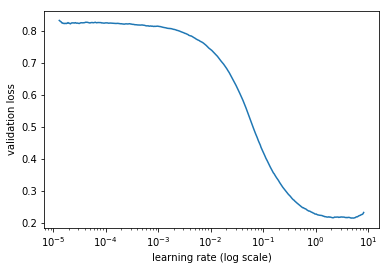

In [43]:
lrf = learn.lr_find()
learn.sched.plot()

In [22]:
lr = 0.2

In [46]:
learn.fit(lr,3,cycle_len=1)

epoch      trn_loss   val_loss   f2                          
    0      0.156859   0.144403   0.868207  
    1      0.150076   0.139775   0.874853                    



[array([0.13977]), 0.8748533257298977]

In [24]:
learn.unfreeze()
lrs=np.array([lr/9,lr/3,lr])

In [23]:
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)

NameError: name 'lrs' is not defined

In [49]:
learn.save(f'{sz}')

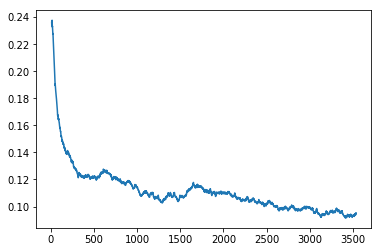

In [50]:
learn.sched.plot_loss()

In [20]:
sz=128

In [25]:
learn.set_data(get_data(sz,bs))
learn.freeze()
learn.fit(lr,3,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.137478   0.120454   0.896756  
    1      0.129548   0.115429   0.902038                    
    2      0.128717   0.112571   0.904783                    
    3      0.130102   0.11136    0.905803                    
    4      0.123881   0.109823   0.906651                    
    5      0.123192   0.108692   0.908207                    
    6      0.118492   0.108509   0.908696                    



[array([0.10851]), 0.9086963827314246]

In [26]:
learn.unfreeze()
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                          
    0      0.103531   0.088787   0.927292  
    1      0.101945   0.087428   0.927357                     
    2      0.089924   0.083973   0.930627                     
    3      0.094046   0.086333   0.929469                     
    4      0.089703   0.08302    0.931798                     
    5      0.085189   0.081187   0.934521                     
    6      0.080888   0.081061   0.93336                      



In [27]:
learn.load(f'{sz}')

In [28]:
sz=256

In [ ]:
learn.set_data(get_data(sz,bs))
learn.freeze()
learn.fit(lr,3,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.093307   0.084285   0.9303    
    1      0.089586   0.084142   0.929521                     
 92%|█████████▏| 463/506 [05:16<00:29,  1.48it/s, loss=0.0864]

In [ ]:
learn.unfreeze()
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
tta = learn.TTA()

In [ ]:
f2(*tta) 

In [ ]:
#EVALUACE

In [ ]:
log_preds,y=learn.TTA()
accuracy_np(log_preds,y)

In [ ]:
preds = np.argmax(log_preds,axis=1)
probs = np.exp(log_preds[:,1])

In [ ]:
from sklearn.metrics import confussion_matrix
cm = confussion_matrix(y,preds)
plot_confussion_matrix(cm,data.classes)